In [ ]:
import os

def count_files_in_folder(folder_path):
    try:
        # List all files in the directory
        files = os.listdir(folder_path)

        # Count files only (excluding directories)
        file_count = 0
        for file in files:
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                file_count += 1

        return file_count

    except FileNotFoundError:
        print(f"Error: The folder '{folder_path}' does not exist.")
        return None

# Example usage:
folder_path = '/content/drive/MyDrive/AYYO DEVARE/Result/NORMAL ENC 3.5'
num_files = count_files_in_folder(folder_path)
if num_files is not None:
    print(f"Number of files in '{folder_path}': {num_files}")


Number of files in '/content/drive/MyDrive/AYYO DEVARE/Result/NORMAL ENC 3.5': 3000


57/57 [==============================] - 11s 186ms/step - loss: 0.8499 - accuracy: 0.7347
Test loss: 0.8499
Test accuracy: 0.7347
57/57 [==============================] - 10s 179ms/step
Validation loss: 0.8331
Validation accuracy: 0.7217


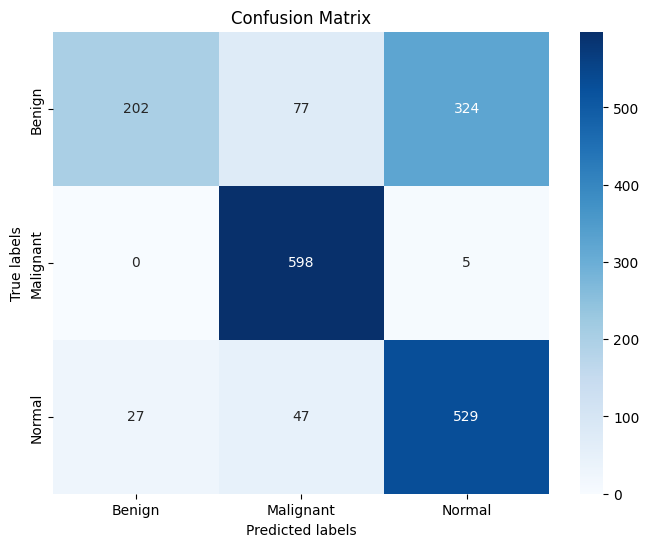

Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.33      0.49       603
   Malignant       0.83      0.99      0.90       603
      Normal       0.62      0.88      0.72       603

    accuracy                           0.73      1809
   macro avg       0.78      0.73      0.70      1809
weighted avg       0.78      0.73      0.70      1809



In [ ]:

import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Function to preprocess images
def preprocess_image(file_path, label):
    img = load_img(file_path, target_size=(224, 224))  # Load image and resize to 224x224
    img_array = img_to_array(img)  # Convert image to numpy array
    img_array = preprocess_input(img_array)  # Preprocess image for MobileNet
    return img_array, label

# Function to load dataset and preprocess images
def load_dataset(benign_dir, malignant_dir, normal_dir):
    images = []
    labels = []
    label_map = {'benign': 0, 'malignant': 1, 'normal': 2}

    for label_name, label_dir in zip(['benign', 'malignant', 'normal'], [benign_dir, malignant_dir, normal_dir]):
        if os.path.isdir(label_dir):
            label = label_map[label_name]
            for filename in os.listdir(label_dir):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    img_path = os.path.join(label_dir, filename)
                    img_array, label = preprocess_image(img_path, label)
                    images.append(img_array)
                    labels.append(label)

    images = np.array(images)
    labels = to_categorical(labels, num_classes=3)  # Convert labels to one-hot encoded vectors
    return images, labels

# Define paths to the directories containing images for each class
benign_dir = '/content/drive/MyDrive/AYYO DEVARE/Result/BENIGN ENC 3.5'
malignant_dir ='/content/drive/MyDrive/AYYO DEVARE/Result/MALIGNANT ENC 3.5'
normal_dir = '/content/drive/MyDrive/AYYO DEVARE/Result/NORMAL ENC 3.5'

# Load dataset
images, labels = load_dataset(benign_dir, malignant_dir, normal_dir)

# Split dataset into training, validation, and testing sets for each class (70% train, 10% val, 20% test)
# Use stratify to ensure balanced distribution of classes in each split
# First, split the data for 'benign' class
benign_train_images, benign_val_test_images, benign_train_labels, benign_val_test_labels = train_test_split(
    images[labels[:, 0] == 1],  # Select images where the first column of labels is 1 (benign class)
    labels[labels[:, 0] == 1],  # Corresponding labels for benign class
    test_size=0.3,              # 30% for validation + test
    random_state=42,            # Random seed for reproducibility
    stratify=labels[labels[:, 0] == 1]  # Ensure stratified split based on benign class labels
)

# Further split validation + test set for 'benign' class
benign_val_images, benign_test_images, benign_val_labels, benign_test_labels = train_test_split(
    benign_val_test_images,
    benign_val_test_labels,
    test_size=0.67,  # 67% of 30% goes to test set
    random_state=42,
    stratify=benign_val_test_labels  # Ensure stratified split within validation + test set
)

# Repeat the above steps for 'malignant' class
malignant_train_images, malignant_val_test_images, malignant_train_labels, malignant_val_test_labels = train_test_split(
    images[labels[:, 1] == 1],
    labels[labels[:, 1] == 1],
    test_size=0.3,
    random_state=42,
    stratify=labels[labels[:, 1] == 1]
)

malignant_val_images, malignant_test_images, malignant_val_labels, malignant_test_labels = train_test_split(
    malignant_val_test_images,
    malignant_val_test_labels,
    test_size=0.67,  # 67% of 30% goes to test set
    random_state=42,
    stratify=malignant_val_test_labels  # Ensure stratified split within validation + test set
)

# Repeat the above steps for 'normal' class
normal_train_images, normal_val_test_images, normal_train_labels, normal_val_test_labels = train_test_split(
    images[labels[:, 2] == 1],
    labels[labels[:, 2] == 1],
    test_size=0.3,
    random_state=42,
    stratify=labels[labels[:, 2] == 1]
)

# Further split validation + test set for 'normal' class
normal_val_images, normal_test_images, normal_val_labels, normal_test_labels = train_test_split(
    normal_val_test_images,
    normal_val_test_labels,
    test_size=0.67,  # 67% of 30% goes to test set
    random_state=42,
    stratify=normal_val_test_labels  # Ensure stratified split within validation + test set
)


# Concatenate augmented 'normal' training data with original 'benign' and 'malignant' training data
train_images = np.concatenate((benign_train_images, malignant_train_images, normal_train_images), axis=0)
train_labels = np.concatenate((benign_train_labels, malignant_train_labels,normal_train_labels), axis=0)

val_images = np.concatenate((benign_val_images, malignant_val_images, normal_val_images), axis=0)
val_labels = np.concatenate((benign_val_labels, malignant_val_labels, normal_val_labels), axis=0)

test_images = np.concatenate((benign_test_images, malignant_test_images, normal_test_images), axis=0)
test_labels = np.concatenate((benign_test_labels, malignant_test_labels, normal_test_labels), axis=0)

# Print shapes to verify
print(f"Train images shape: {train_images.shape}")

print(f"Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

from tensorflow.keras.applications import InceptionV3

# Load MobileNet model with pre-trained weights (excluding the top layers)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base MobileNet layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
model = Sequential()

# Add the pre-trained base model
model.add(base_model)

# Add a Global Average Pooling 2D layer
model.add(GlobalAveragePooling2D())

# Add the final output layer with 3 units (assuming 3 classes) and softmax activation
model.add(Dense(3, activation='softmax'))

# Print model summary
model.summary()

# Define learning rate
learning_rate = 0.002  # Adjust the learning rate as needed

# Compile the model with Adam optimizer and custom learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming `train_images`, `train_labels`, `val_images`, `val_labels`, `test_images`, `test_labels` are defined elsewhere

# Train the model using augmented training data
history = model.fit(train_images, train_labels, epochs=10, batch_size=8, validation_data=(val_images, val_labels))


import matplotlib.pyplot as plt
import seaborn as sns


# Evaluate the model on test data
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Predict labels for test set
y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Compute validation loss and accuracy from history
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f'Validation loss: {val_loss:.4f}')
print(f'Validation accuracy: {val_accuracy:.4f}')

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_labels)
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Benign', 'Malignant', 'Normal'], yticklabels=['Benign', 'Malignant', 'Normal'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_names = ['Benign', 'Malignant', 'Normal']
print('Classification Report:')
print(classification_report(true_labels, y_pred_labels, target_names=class_names))


219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 3)                 4611      
                                                                 
Total params: 54341347 (207.30 MB)
Trainable params: 4611 (18.01 KB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________
Epoch 1/10
788/788 [==============================] - 238s 289ms/step - l

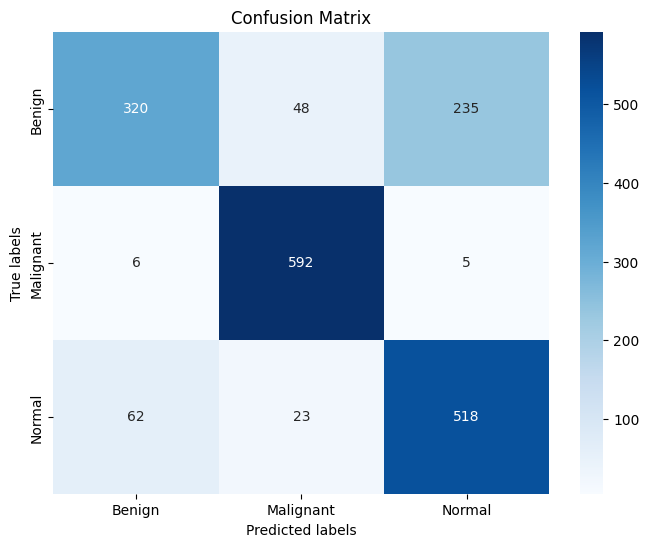

Classification Report:
              precision    recall  f1-score   support

      Benign       0.82      0.53      0.65       603
   Malignant       0.89      0.98      0.94       603
      Normal       0.68      0.86      0.76       603

    accuracy                           0.79      1809
   macro avg       0.80      0.79      0.78      1809
weighted avg       0.80      0.79      0.78      1809



In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications import InceptionResNetV2

# Load MobileNet model with pre-trained weights (excluding the top layers)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base MobileNet layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
model = Sequential()

# Add the pre-trained base model
model.add(base_model)

# Add a Global Average Pooling 2D layer
model.add(GlobalAveragePooling2D())

# Add the final output layer with 3 units (assuming 3 classes) and softmax activation
model.add(Dense(3, activation='softmax'))

# Print model summary
model.summary()

# Define learning rate
learning_rate = 0.002  # Adjust the learning rate as needed

# Compile the model with Adam optimizer and custom learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming `train_images`, `train_labels`, `val_images`, `val_labels`, `test_images`, `test_labels` are defined elsewhere

# Train the model using augmented training data
history = model.fit(train_images, train_labels, epochs=10, batch_size=8, validation_data=(val_images, val_labels))

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Predict labels for test set
y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Compute validation loss and accuracy from history
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f'Validation loss: {val_loss:.4f}')
print(f'Validation accuracy: {val_accuracy:.4f}')

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Benign', 'Malignant', 'Normal'], yticklabels=['Benign', 'Malignant', 'Normal'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_names = ['Benign', 'Malignant', 'Normal']
print('Classification Report:')
print(classification_report(true_labels, y_pred_labels, target_names=class_names))

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 20867627 (79.60 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________
Epoch 1/10
788/788 [==============================] - 144s 179ms/step - loss: 0.5837 - accuracy: 0.7470 - val_loss: 0.4806 - val_accuracy: 0.80

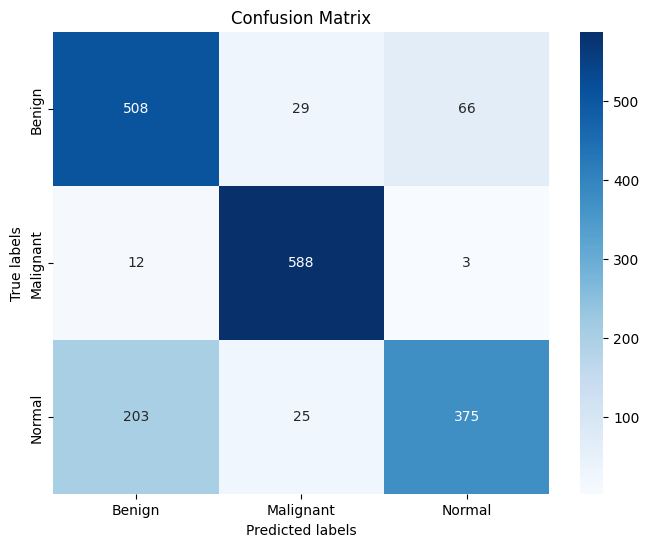

Classification Report:
              precision    recall  f1-score   support

      Benign       0.70      0.84      0.77       603
   Malignant       0.92      0.98      0.94       603
      Normal       0.84      0.62      0.72       603

    accuracy                           0.81      1809
   macro avg       0.82      0.81      0.81      1809
weighted avg       0.82      0.81      0.81      1809



In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications import Xception

# Load MobileNet model with pre-trained weights (excluding the top layers)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base MobileNet layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
model = Sequential()

# Add the pre-trained base model
model.add(base_model)

# Add a Global Average Pooling 2D layer
model.add(GlobalAveragePooling2D())

# Add the final output layer with 3 units (assuming 3 classes) and softmax activation
model.add(Dense(3, activation='softmax'))

# Print model summary
model.summary()

# Define learning rate
learning_rate = 0.002  # Adjust the learning rate as needed

# Compile the model with Adam optimizer and custom learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming `train_images`, `train_labels`, `val_images`, `val_labels`, `test_images`, `test_labels` are defined elsewhere

# Train the model using augmented training data
history = model.fit(train_images, train_labels, epochs=10, batch_size=8, validation_data=(val_images, val_labels))

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Predict labels for test set
y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Compute validation loss and accuracy from history
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f'Validation loss: {val_loss:.4f}')
print(f'Validation accuracy: {val_accuracy:.4f}')

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Benign', 'Malignant', 'Normal'], yticklabels=['Benign', 'Malignant', 'Normal'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_names = ['Benign', 'Malignant', 'Normal']
print('Classification Report:')
print(classification_report(true_labels, y_pred_labels, target_names=class_names))

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 7040579 (26.86 MB)
Trainable params: 3075 (12.01 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________
Epoch 1/10
788/788 [==============================] - 172s 211ms/step - loss: 0.4731 - accuracy: 0.7860 - val_loss: 0.3930 - val_accuracy: 0.8294

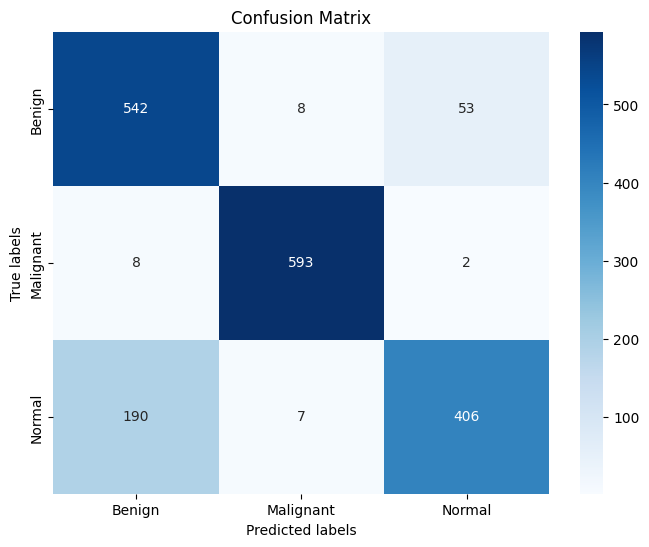

Classification Report:
              precision    recall  f1-score   support

      Benign       0.73      0.90      0.81       603
   Malignant       0.98      0.98      0.98       603
      Normal       0.88      0.67      0.76       603

    accuracy                           0.85      1809
   macro avg       0.86      0.85      0.85      1809
weighted avg       0.86      0.85      0.85      1809



In [ ]:

from tensorflow.keras.applications import DenseNet121

# Load MobileNet model with pre-trained weights (excluding the top layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base MobileNet layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
model = Sequential()

# Add the pre-trained base model
model.add(base_model)

# Add a Global Average Pooling 2D layer
model.add(GlobalAveragePooling2D())

# Add the final output layer with 3 units (assuming 3 classes) and softmax activation
model.add(Dense(3, activation='softmax'))

# Print model summary
model.summary()

# Define learning rate
learning_rate = 0.002  # Adjust the learning rate as needed

# Compile the model with Adam optimizer and custom learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming `train_images`, `train_labels`, `val_images`, `val_labels`, `test_images`, `test_labels` are defined elsewhere

# Train the model using augmented training data
history = model.fit(train_images, train_labels, epochs=10, batch_size=8, validation_data=(val_images, val_labels))

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Predict labels for test set
y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Compute validation loss and accuracy from history
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f'Validation loss: {val_loss:.4f}')
print(f'Validation accuracy: {val_accuracy:.4f}')

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Benign', 'Malignant', 'Normal'], yticklabels=['Benign', 'Malignant', 'Normal'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_names = ['Benign', 'Malignant', 'Normal']
print('Classification Report:')
print(classification_report(true_labels, y_pred_labels, target_names=class_names))